### Mean-Variance Potfolio Optimization with Elastic Net Penalty


In [190]:
import pylops 
import numpy as np
import pandas as pd
import scipy.optimize
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix, csc_array
import matplotlib.pyplot as plt

###  Returns below
- Note log returns have caused some issues numerically within optimiztion

In [305]:
equity_data=pd.read_csv('equity_data_2019.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])

returns=(equity_data/equity_data.shift(1))-1
returns=returns.fillna(0)
returns=returns.iloc[1:]
frac=0.5
cutoff=np.floor(frac*len(returns.index)).astype(int)

returns_train=returns.iloc[:cutoff]
returns_test=returns.iloc[cutoff:]

returns_train

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.004359,-0.005587,-0.000233,-0.004166,-0.002816,0.005205,-0.012759,0.011161,0.004023,0.002437,...,0.006880,-0.012072,0.018904,0.010084,-0.000277,-0.002493,-0.025117,0.020823,-0.010857,0.015655
2016-01-06,-0.020141,-0.019797,-0.008388,0.000174,0.003529,-0.001954,-0.009424,-0.024283,-0.014295,-0.012277,...,0.000000,-0.003155,-0.051805,0.010538,-0.012476,-0.007080,-0.039957,0.004330,-0.029145,0.000208
2016-01-07,-0.024362,-0.048854,-0.023966,-0.002963,-0.039625,-0.029366,-0.014134,-0.023756,-0.020984,-0.030519,...,-0.086538,-0.009646,-0.094070,0.003842,-0.025828,-0.034116,-0.045316,-0.022993,-0.030020,-0.030404
2016-01-08,-0.003405,-0.035581,-0.020944,-0.027268,0.032471,-0.009681,-0.015440,-0.003766,-0.014140,-0.008251,...,0.014528,-0.011870,-0.040704,-0.010935,-0.009510,-0.013607,-0.002693,-0.004217,-0.011254,-0.014605
2016-01-11,-0.000214,-0.025885,0.001475,-0.031806,0.004966,0.010489,0.014002,-0.006688,0.017416,0.004864,...,-0.014149,-0.029108,-0.016453,0.008016,-0.008438,-0.001761,-0.006582,-0.017233,-0.019919,-0.028335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-0.000213,-0.007292,0.000000,0.003064,0.005298,-0.002010,-0.008758,0.002494,0.002521,-0.004429,...,-0.004135,-0.000766,-0.004510,-0.002893,-0.002509,-0.001212,-0.012954,0.001417,-0.002526,-0.004012
2017-12-26,0.003067,0.006530,0.001230,-0.004684,-0.010958,-0.005848,-0.016432,0.001742,-0.003200,0.005904,...,0.000857,0.004982,0.005186,-0.008705,-0.001184,-0.002549,-0.003424,-0.001332,-0.009156,0.004862
2017-12-27,0.003185,0.003568,0.008246,0.003478,0.004643,0.002157,-0.001734,-0.000497,0.005274,-0.002637,...,-0.001514,0.004195,0.009430,-0.000627,0.010815,0.002555,0.001527,0.001501,-0.002949,0.001521


### Computation of Naive mean and covariance estimation from sample

In [306]:
returns_mean=returns_train.mean().values
returns_cov=np.cov(returns_train.T)

Text(0, 0.5, 'Freq')

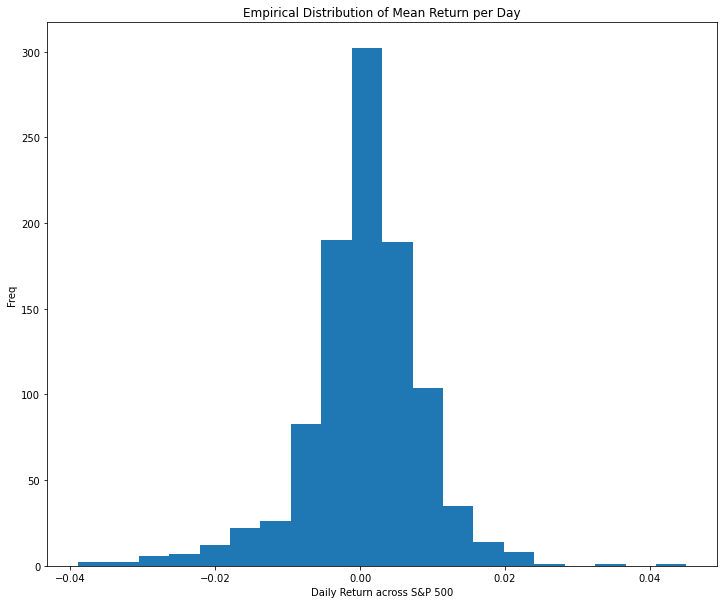

In [307]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(returns.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

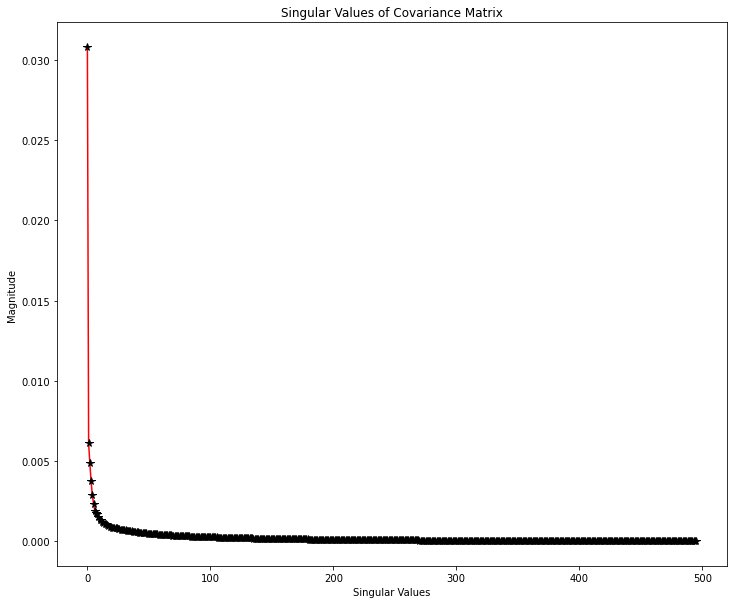

In [308]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Mean and Covariance Estimators 

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
    - Can solve numerically via unconstrained minimization
    - Solve analytically via QPSolvers
- Applies shrinkage (L1) penalty within outer loop


In [309]:
def qp(cov,mean,w,d,b,beta,lambda1,tol,maxiter,approach):
    """ Inner optimization problem using unconstrained optimization 
        Approach 1 solves numerically via unconstrained minimization
        Approach 2 solves analytically via qpsolvers 
    """
    
    x0=w # initial guess is previous result
    
    if approach==1:
        # Numerical soln is much slower as unconstrained minimization
        def objective_val(w,cov,mean,d,b,beta,lambda1):
            """ MPT objective
            """

            obj=np.dot(np.dot(w,cov),w)-np.dot(w,mean)

            l2_pen=np.sum((d-beta*w-b)**2)

            return obj+lambda1*l2_pen/2

        res=scipy.optimize.minimize(objective_val,x0=w,args=(returns_cov,returns_mean,d,b,beta,lambda1),method='CG',options={'maxiter':25},tol=1e-12)
        w=res.x
        
    if approach==2:
        # analytical soln is very fast
        sparse_cov=csc_matrix(2*(cov+2*lambda1*np.identity(len(w))))
        mean=-1*mean
        w = solve_qp(sparse_cov,mean,initvals=x0, solver="osqp")
    return w

def shrinkage(w,d,b,lambda1,beta):
    """ Shrinkage operator; second optimization routine
    """
    
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  # elementwise max
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,beta=None,tol=1e-10,maxiter=100,approach=2):
    """ Split Bregman Optimization Routine
    """

    error=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.zeros(n)
    d=np.zeros(n)
    
    
    i=0
    while error>tol:
        if i>maxiter:
            print("MaxIter Achieved")
            break
            
        
        if i%25==0 and i>0:
            print(f"{i}-th iteration with error of {error}")
        
        w_old=w
        w=qp(cov,mean,w_old,d,b,beta,lambda1,tol,maxiter,approach)
        error=np.sum((w-w_old)**2)
        
        d=shrinkage(w,d,b,lambda1,beta)
        b=b+w-d       
        i+=1
    
    
    print(f"Terminated in {i} iterations of error {error}")
    unit_w=w/np.linalg.norm(w,ord=1)
    return unit_w, error



### Numerical Results

- 10x magnitude on lambda1 param

In [344]:
lambda1=10e-4

w0,error1=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 2 iterations of error 4.115565788172943e-11


Text(0, 0.5, 'Weight Allocation')

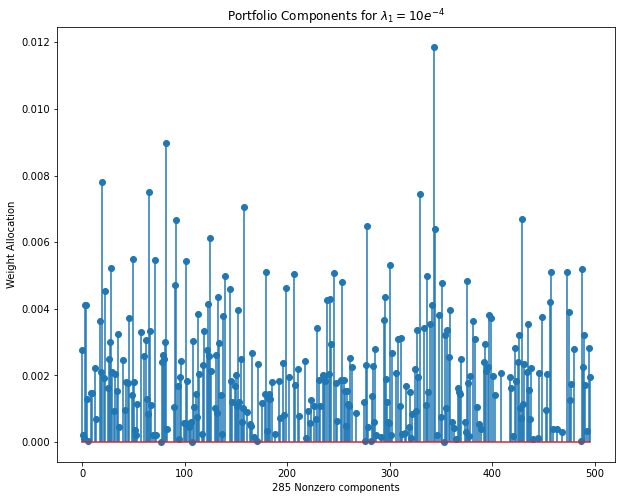

In [345]:
nonzero_w0=np.where(w0>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10e^{-4}$")
ax.stem(nonzero_w0,w0[nonzero_w0])
plt.xlabel(f"{len(nonzero_w0)} Nonzero components")
plt.ylabel("Weight Allocation")

In [346]:
lambda1=5e-4
w1,error1=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 2 iterations of error 1.2135459460784827e-10


Text(0, 0.5, 'Weight Allocation')

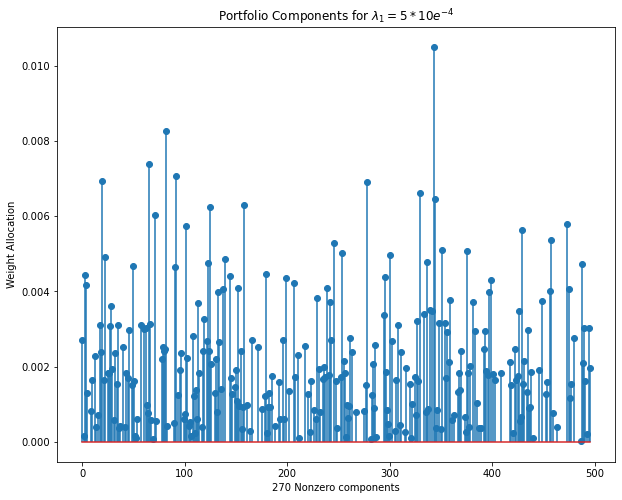

In [379]:
nonzero_w1=np.where(w1>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=5*10e^{-4}$")
ax.stem(nonzero_w1,w1[nonzero_w1])
plt.xlabel(f"{len(nonzero_w1)} Nonzero components")
plt.ylabel("Weight Allocation")

In [348]:
lambda1=1e-4
w2,error2=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 2 iterations of error 1.3391361074249092e-09


Text(0, 0.5, 'Weight Allocation')

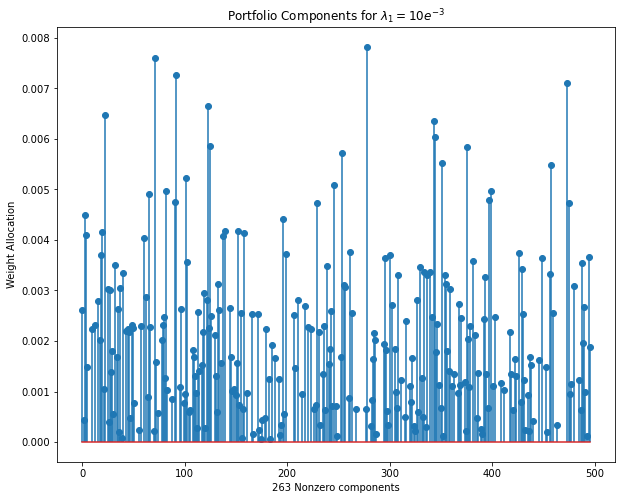

In [359]:
nonzero_w2=np.where(w2>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10e^{-3}$")
ax.stem(nonzero_w2,w2[nonzero_w2])
plt.xlabel(f"{len(nonzero_w2)} Nonzero components")
plt.ylabel("Weight Allocation")


In [367]:
lambda1=5e-3
w3,error3=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 2 iterations of error 2.9300249182590464e-12


Text(0, 0.5, 'Weight Allocation')

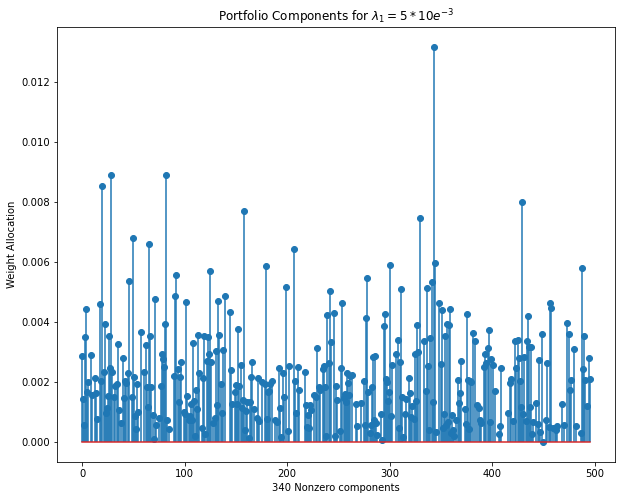

In [380]:
nonzero_w3=np.where(w3>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=5*10e^{-3}$")
ax.stem(nonzero_w3,w3[nonzero_w3])
plt.xlabel(f"{len(nonzero_w3)} Nonzero components")
plt.ylabel("Weight Allocation")

### Grid Search Lambda Values 

In [384]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=25):
    results={}
    for i in params:
        w,error=split_bregman(returns_cov,returns_mean,lambda1=i,tol=1e-8,maxiter=25,approach=2)
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

lambda_grid=np.logspace(-4,4,12)

sorted_dict=grid_search(lambda_grid,returns_mean,returns_cov)

Terminated in 2 iterations of error 1.3391361074249092e-09
Terminated in 2 iterations of error 1.0981595624192344e-10
Terminated in 2 iterations of error 7.446340045765016e-12
Terminated in 2 iterations of error 4.870563113726855e-13
Terminated in 2 iterations of error 2.906546387855068e-14
Terminated in 2 iterations of error 1.2194233338640858e-15
Terminated in 2 iterations of error 4.448374394681279e-17
Terminated in 2 iterations of error 1.5734356201428191e-18
Terminated in 1 iterations of error 6.8454224500162765e-09
Terminated in 1 iterations of error 2.4041834164020334e-10
Terminated in 1 iterations of error 8.44195985215955e-12
Terminated in 1 iterations of error 2.964161002356715e-13


Text(0, 0.5, 'Weight Allocation')

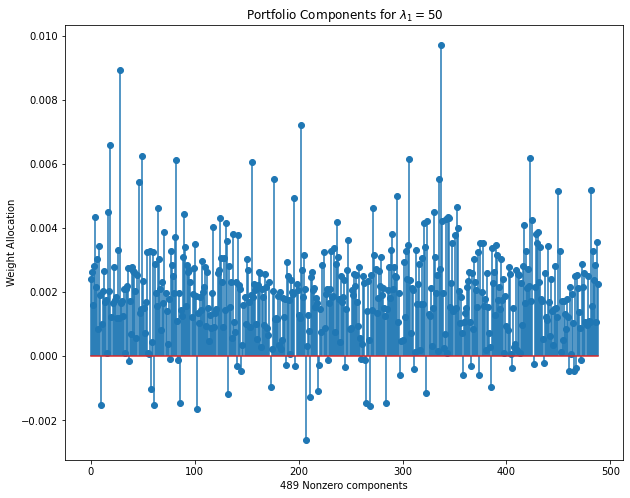

In [385]:
wi=sorted_dict[0][1][0]
nonzero_wi=np.where(abs(wi)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [371]:
print(f"Largest Component is {max(abs(wi[nonzero_wi]))}")
print(f"Smallest Component is {min(abs(wi[nonzero_wi]))}")

Largest Component is 0.009714080789110551
Smallest Component is 6.716334478227217e-05


### Sharpe Ratio Performance 

In [372]:
returns_test

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.001147,0.004080,0.030138,0.017578,0.027106,0.004899,0.015635,0.000249,0.014038,-0.010240,...,-0.024554,-0.002286,-0.025446,-0.006236,-0.001906,-0.000123,-0.000867,0.028093,-0.002558,-0.003748
2018-01-03,-0.000042,0.006013,0.002211,0.015649,0.017300,0.004615,0.015550,-0.007733,0.018796,0.010863,...,0.018709,-0.006279,-0.010834,-0.006693,0.012193,-0.000858,0.019863,0.006932,-0.001183,0.004598
2018-01-04,0.013071,0.004685,-0.001697,-0.005703,0.017516,0.011841,-0.009952,0.016843,0.012042,0.009552,...,0.010151,0.007813,0.005415,-0.007791,0.006676,0.010180,0.019760,-0.001441,0.004147,0.005964
2018-01-05,0.007792,0.012864,0.002890,0.017408,0.015408,0.008249,0.026446,-0.006675,0.011571,-0.000591,...,0.006413,0.009277,0.006671,-0.007003,-0.001874,0.005828,0.015576,0.009941,0.000393,0.011444
2018-01-08,-0.003242,0.004763,-0.002882,-0.016022,0.027086,0.007991,0.003917,-0.002240,-0.001619,-0.003043,...,-0.005387,0.000000,-0.013314,0.007480,0.003611,0.001690,0.009951,0.001905,-0.004914,0.011996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.010030,0.007637,-0.000801,-0.004432,0.010913,0.003700,-0.001358,0.001304,0.002098,-0.000647,...,0.002034,-0.001007,-0.005634,-0.002539,-0.003927,0.005210,-0.009348,-0.002446,0.003701,0.004155
2019-12-26,-0.000509,0.005053,0.000000,-0.000223,-0.007487,0.002079,0.001360,0.002604,0.004732,0.002590,...,0.000149,0.004535,0.010757,-0.001114,-0.000509,0.014552,0.000354,-0.003778,0.002523,0.000828
2019-12-27,0.003794,0.001466,0.001375,-0.007013,-0.010175,0.000802,0.005094,0.002164,-0.001238,0.002466,...,-0.001287,-0.004249,-0.008018,0.005256,0.003053,0.001081,0.006210,-0.001929,-0.003097,0.001654


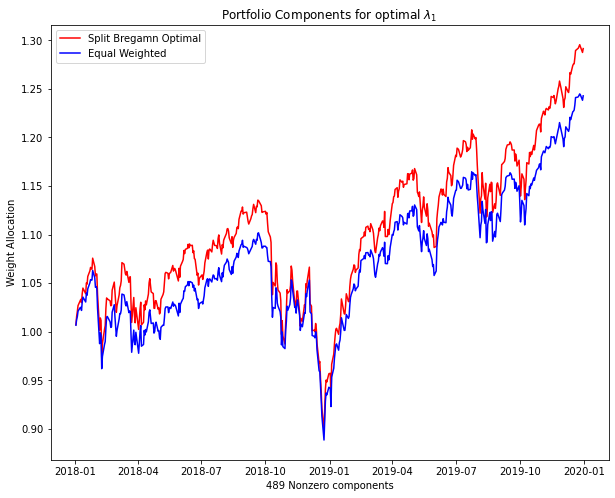

In [373]:
cum_returns_split_1=np.cumprod(1+np.dot(wi,returns_test.T))

equal=(1/returns_test.shape[1])*np.ones(returns_test.shape[1])
cum_returns_equal=np.cumprod(1++np.dot(equal,returns_test.T))
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for optimal $\lambda_1$")
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_1,label='Split Bregamn Optimal',color='red')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_equal,label='Equal Weighted',color='blue')
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")
plt.legend()





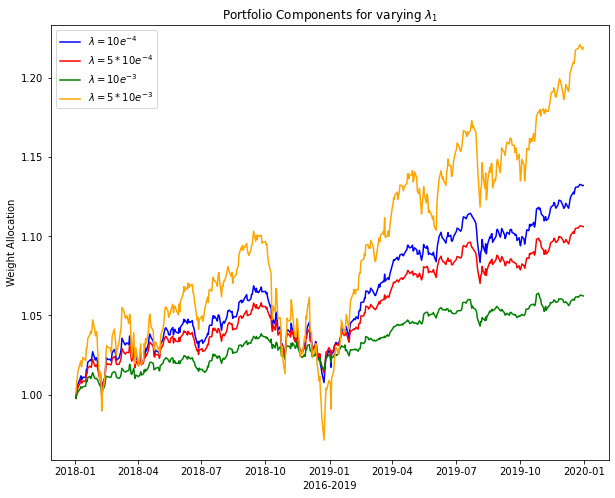

In [378]:
cum_returns_split_0=np.cumprod(1+np.dot(w0,returns_test.T))
cum_returns_split_1=np.cumprod(1+np.dot(w1,returns_test.T))
cum_returns_split_2=np.cumprod(1+np.dot(w2,returns_test.T))
cum_returns_split_3=np.cumprod(1+np.dot(w3,returns_test.T))

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for varying $\lambda_1$")
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_0,label='$\lambda=10e^{-4}$',color='blue')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_1,label='$\lambda=5*10e^{-4}$',color='red')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_2,label='$\lambda=10e^{-3}$',color='green')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_3,label='$\lambda=5*10e^{-3}$',color='orange')
plt.xlabel("2016-2019")
plt.ylabel("Weight Allocation")
plt.legend()

